# JAX Scratch Code
For learning and experimenting with JAX

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)


In [21]:
import equinox as eqx
import interpax
import diffrax

In [3]:
# %% Set up other imports
import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt

In [9]:
# %% Electron cyclotron motion test

# Mass, charge, and magnetic field strength
Params = namedtuple('Params', ['m', 'q', 'b0'])

# TODO: Test that interpolators can be passed into jitted functions?

def f_slab(state, t, params: Params):
    """
    ODE function for electron cyclotron motion in a uniform magnetic field.

    state: (x,p) pytree with x,p shape (N,3)
    """
    x, p = state

    dxdt = p / params.m
    dpdt = params.q * jnp.cross(p / params.m, params.b0)

    return (dxdt, dpdt)

In [16]:

# %% Interpolation class?

class FieldTest(eqx.Module):
    rgrid: jnp.ndarray
    zgrid: jnp.ndarray
    psirz: jnp.ndarray
    interp: interpax.Interpolator2D

    def __init__(self, rgrid, zgrid, psirz):
        self.rgrid = rgrid
        self.zgrid = zgrid
        self.psirz = psirz
        self.interp = interpax.Interpolator2D(rgrid, zgrid, psirz, method='cubic2')

    def compute_terms(self, x, y):
        fx = self.interp(x, y, dx=1)
        fy = self.interp(x, y, dy=1)
        return (fx, fy)

def f_test(state, t, field: FieldTest):
    x, y = state
    fx, fy = field.compute_terms(x, y)
    dxdt = -fy
    dydt = fx
    return (dxdt, dydt)




# ---- PyTree helpers for RK4 ----
def tree_addmul(y, a, dy):
    # y + a * dy (for PyTrees with same structure)
    return jtu.tree_map(lambda yi, dyi: yi + a * dyi, y, dy)

def tree_lincomb(coeffs, trees):
    # sum_i coeffs[i] * trees[i]
    return jtu.tree_map(lambda *leaves: sum(c * l for c, l in zip(coeffs, leaves)), *trees)

## RK4 Stepper
def rk4_step(state, t, dt, rhs, field: FieldTest):
    k1 = rhs(state                         , t         , field)
    k2 = rhs(tree_addmul(state, 0.5*dt, k1), t + 0.5*dt, field)
    k3 = rhs(tree_addmul(state, 0.5*dt, k2), t + 0.5*dt, field)
    k4 = rhs(tree_addmul(state,     dt, k3), t + dt    , field)
    incr = tree_lincomb([dt/6, dt/3, dt/3, dt/6], [k1, k2, k3, k4])
    return tree_addmul(state, 1.0, incr)

## Actual simulation function
@partial(jax.jit, static_argnames=['dt', 'steps'])
def simulate(state0, field: FieldTest, dt: float, steps: int):
    """
    Returns arrays of positions and velocities
    """

    def body(state, i):
        t = i * dt
        new_state = rk4_step(state, t, dt, f_test, field)
        return new_state, new_state

    # collect states at each step
    stateT, traj = jax.lax.scan(body, state0, jnp.arange(steps))
    
    return (state0, stateT, traj)

In [17]:

# -------------------------------
# Example: single particle cyclotron orbit
# -------------------------------
if __name__ == "__main__":
    # Number of particles
    N = 1
    # Parameters
    params = Params(m=1.0, q=1.0, b0=jnp.array([0.0, 0.0, 1.0]))

    # FieldTest
    xgrid, ygrid = jnp.linspace(0, 2*jnp.pi, 64), jnp.linspace(0, 2*jnp.pi, 64)
    xmesh, ymesh = jnp.meshgrid(xgrid, ygrid, indexing='ij')
    psirz = jnp.sin(xmesh) * jnp.sin(ymesh)

    field = FieldTest(xgrid, ygrid, psirz)
    

    # Initial conditions: position (m), velocity (m/s)
    #x0 = jnp.array([[1.0, 0.0, 0.0]])   # shape (N,3)
    #v0 = jnp.array([[0.0, 1.0, 1.0]])   # perpendicular to B -> circular orbit

    x = jnp.array([1.0])
    y = jnp.array([1.0])

    # Time step and duration
    omega_c = 1.0
    T_c = 2 * jnp.pi / omega_c                             # period
    steps_per_period = 400                                 # finer -> better energy behavior
    dt = T_c / steps_per_period
    n_periods = 5
    steps = int(steps_per_period * n_periods)

    state0, stateT, traj = simulate((x, y), field, dt, steps)

In [14]:
traj[0].shape

(2000, 1)

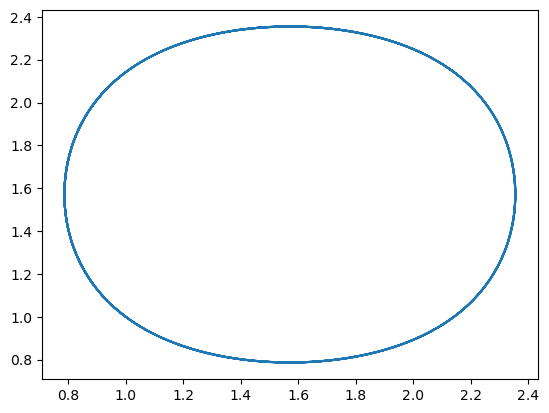

In [18]:
plt.figure()

x, y = traj

plt.plot(x, y)

In [ ]:
# %% Using diffrax

def f_test_diffrax(t, state, args):
    pass